# This is a version of the paper's Figure 12 that is a 3D animation

In [1]:
from __future__ import division, print_function

import cPickle as pickle

import numpy as np
from scipy.spatial import cKDTree
from scipy import stats, special

from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import SkyCoord, Distance
from astropy.coordinates.angles import rotation_matrix

from astropy.wcs import WCS
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.cosmology import WMAP9

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import rcParams, animation
from matplotlib import transforms as mtransforms
from mpl_toolkits.mplot3d import Axes3D

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

# Load data and set up spatial coordinates 

In [3]:
#distances from MCMC
npz = np.load('PiscAB_distances_2015_12_15.npz')
PiscA_dist = Distance(npz['piscA_dist_Mpc'], u.Mpc)
PiscB_dist = Distance(npz['piscB_dist_Mpc'], u.Mpc)

PiscA = SkyCoord('00h14m46s', '+10d48m47.01s', distance=Distance(np.percentile(PiscA_dist, [50, 16, 84]), u.Mpc))
PiscB = SkyCoord('01h19m11.7s', '+11d7m18.22s', distance=Distance(np.percentile(PiscB_dist, [50, 16, 84]), u.Mpc))

PiscA_MHI = [2.8, .2] *u.solMass*1e5 * u.Mpc**-2 # value, unc
PiscB_MHI = [3.8, .4] *u.solMass*1e5 * u.Mpc**-2 # value, unc

In [4]:
ml = ascii.read('masterlist.csv')

In [5]:
msk = (ml['distance']>0)&(ml['distance']<15)
mml = ml[msk]
mlsc = SkyCoord(mml['RA']*u.deg, mml['Dec']*u.deg, distance=Distance(mml['distance'], u.Mpc))
mlcart = mlsc.cartesian
mlgcart = mlsc.galactic.cartesian
Kabsm = mml['K'] - mlsc.distance.distmod.value

In [6]:
local_void_sc = SkyCoord('18h38m', '18d')

local_void_xyz = local_void_sc.galactic.cartesian.xyz
x = mlgcart.x
y = mlgcart.y
z = mlgcart.z

mat1 = rotation_matrix(-local_void_sc.galactic.b, 'y')
mat2 = rotation_matrix(local_void_sc.galactic.l, 'z')
R1 = mat1 * mat2

zlv, xlv, ylv = np.dot(R1.A, [x,y,z]) # the above transform sends the *x* axis to the LV axis

zA, yA, xA = np.dot(R1.A, [PiscA.galactic.cartesian.x, PiscA.galactic.cartesian.y, PiscA.galactic.cartesian.z])
zB, yB, xB = np.dot(R1.A, [PiscB.galactic.cartesian.x, PiscB.galactic.cartesian.y, PiscB.galactic.cartesian.z])

In [7]:
twomasslimit = 13.5*u.mag-Distance(2**0.5*10*u.Mpc).distmod
mlgcomplmsk = Kabsm < twomasslimit.value

## Make sure the 2D version looks like Figure 12 (from Calibrated Context.ipynb) 

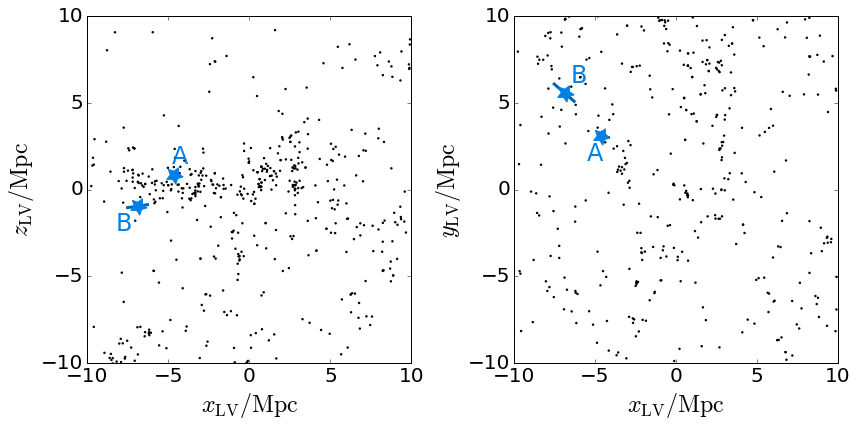

In [8]:
plt.figure(figsize=(12,6))
labelfontsz = 24
tickfontsz = 20
ptscolor = 'k'
pisccolor = (0.,0.5,0.9)
piscunccolor = (0.,0.4,0.7)

plt.subplot(1,2,1)
plt.scatter(xlv[mlgcomplmsk], zlv[mlgcomplmsk], edgecolor='none', s=6, facecolor=ptscolor)
plt.scatter([xA[0], xB[0]], [zA[0], zB[0]], color=pisccolor, marker=(5, 1, 45), s=300, zorder=2)
plt.plot([xA[1], xA[2]], [zA[1], zA[2]], color=piscunccolor, lw=3, zorder=1)
plt.plot([xB[1], xB[2]], [zB[1], zB[2]], color=piscunccolor, lw=3, zorder=1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xticks(fontsize=tickfontsz)
plt.yticks(fontsize=tickfontsz)
plt.xlabel(r'$x_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)
plt.ylabel(r'$z_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)

plt.annotate('A', (xA[0], zA[0]), (6, 6), textcoords='offset points', ha='center', va='bottom',
             color=pisccolor, fontsize=24)
plt.annotate('B', (xB[0], zB[0]), (-6, -6), textcoords='offset points', ha='right', va='top',
             color=pisccolor, fontsize=24)


plt.subplot(1,2,2)
plt.scatter(xlv[mlgcomplmsk], ylv[mlgcomplmsk], edgecolor='none', s=6, facecolor=ptscolor)
plt.scatter([xA[0], xB[0]], [yA[0], yB[0]], color=pisccolor, marker=(5, 1, 45), s=300, zorder=2)
plt.plot([xA[1], xA[2]], [yA[1], yA[2]], color=piscunccolor, lw=3, zorder=1)
plt.plot([xB[1], xB[2]], [yB[1], yB[2]], color=piscunccolor, lw=3, zorder=1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xticks(fontsize=tickfontsz)
plt.yticks(fontsize=tickfontsz)
plt.xlabel(r'$x_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)
plt.ylabel(r'$y_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)

plt.annotate('A', (xA[0], yA[0]), (-6, -6), textcoords='offset points', ha='center', va='top',
             color=pisccolor, fontsize=24)
plt.annotate('B', (xB[0], yB[0]), (6, 6), textcoords='offset points', ha='left', va='bottom',
             color=pisccolor, fontsize=24)

plt.tight_layout()

## Make the 3D animated version 

In [9]:
%matplotlib nbagg
from matplotlib import animation
rcParams['animation.html'] = 'html5'

# this ioff is necessary otherwise the notebook shows the figure twice
plt.ioff()

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='3d')

def t_to_el(t):
    if t<0.5:
        return 120*t
    else:
        return 120*(1-t)

def t_to_az(t):
    return 360*t

def init():
    ax.scatter3D(xlv[mlgcomplmsk], ylv[mlgcomplmsk], zlv[mlgcomplmsk], s=2, c=ptscolor, 
                 label='Local Galaxies with K<{:.1f}'.format(twomasslimit))
    ax.scatter3D([xA[0], xB[0]], [yA[0], yB[0]], [zA[0], zB[0]], color=pisccolor, marker=(5, 1, 45), s=300, zorder=2, 
                 label='Pisces Dwarfs')
    ax.plot3D([xA[1], xA[2]], [yA[1], yA[2]], [zA[1], zA[2]], color=piscunccolor, lw=3, zorder=1)
    ax.plot3D([xB[1], xB[2]], [yB[1], yB[2]], [zB[1], zB[2]], color=piscunccolor, lw=3, zorder=1)
    
    ax.scatter3D([0], [0], [0], s=30, c='g', label='MW/Earth', edgecolor='none')

    ax.set_xlim3d(-10, 10)
    ax.set_ylim3d(-10, 10)
    ax.set_zlim3d(-10, 10)

    ax.set_xlabel(r'$x_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)
    ax.set_ylabel(r'$y_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)
    ax.set_zlabel(r'$z_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)

    ax.azim = t_to_az(0)
    ax.elev = t_to_el(0)
    
    ax.legend(loc=0, scatterpoints=2)

    fig.tight_layout()
    
def redraw(t=0):
    ax.azim = t_to_az(t)
    ax.elev = t_to_el(t)
    

fps = 30
totframes = fps*10

animation.FuncAnimation(fig, redraw, init_func=init, frames=np.linspace(0,1, totframes), interval=1000/fps)